# Task 3 — Cross-Country Comparison
Load cleaned datasets for Benin, Sierra Leone, and Togo, compare GHI / DNI / DHI across countries,
run simple statistical tests, and produce a short set of observations and a ranking by mean GHI.

### Imports & settings

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


sns.set(style='whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

### Loading the Cleaned CSVs from Task 2

In [4]:
paths = {
    'Benin': r'..\\data\\benin_clean.csv',
    'SierraLeone': r'..\\data\\sierraleone_clean.csv',
    'Togo': r'..\\data\\togo_clean.csv'
}

dfs = {}
for name, p in paths.items():
    try:
        d = pd.read_csv(p, parse_dates=['Timestamp'], infer_datetime_format=True)
        d['country'] = name
        dfs[name] = d
        print(f"Loaded {name}: {d.shape}")
    except FileNotFoundError:
        print(f"File not found: {p} — ensure cleaned CSVs exist at ../data/")
    except Exception as e:
        print(f"Failed to load {name}: {e}")

if not dfs:
    raise RuntimeError("No cleaned CSVs loaded. Place benin_clean.csv, sierraleone_clean.csv, togo_clean.csv in ../data/")


C:\Users\HP\AppData\Local\Temp\ipykernel_20552\1300570854.py:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d = pd.read_csv(p, parse_dates=['Timestamp'], infer_datetime_format=True)


Loaded Benin: (517860, 19)


C:\Users\HP\AppData\Local\Temp\ipykernel_20552\1300570854.py:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d = pd.read_csv(p, parse_dates=['Timestamp'], infer_datetime_format=True)


Loaded SierraLeone: (509308, 19)


C:\Users\HP\AppData\Local\Temp\ipykernel_20552\1300570854.py:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d = pd.read_csv(p, parse_dates=['Timestamp'], infer_datetime_format=True)


Loaded Togo: (516349, 19)


All three files loaded successfully with large sample counts:
- Benin: (517,860, 19)
- SierraLeone: (509,308, 19)
- Togo: (516,349, 19)
These are very large samples, statistical tests will have lots of power and small differences will often be significant.

### Concatenate Datasets

In [5]:
df_all = pd.concat(dfs.values(), ignore_index=True)
print("Combined shape:", df_all.shape)

Combined shape: (1543517, 19)


### Boxplots per metric

C:\Users\HP\AppData\Local\Temp\ipykernel_20552\1428189013.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y=m, data=df_all, palette='Set2')


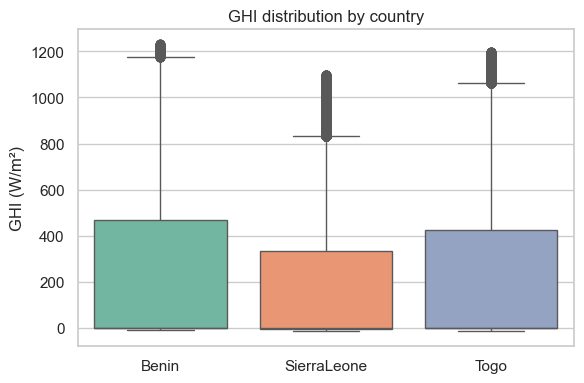

C:\Users\HP\AppData\Local\Temp\ipykernel_20552\1428189013.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y=m, data=df_all, palette='Set2')


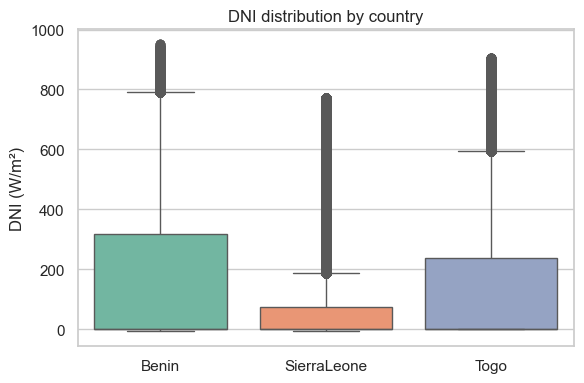

C:\Users\HP\AppData\Local\Temp\ipykernel_20552\1428189013.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y=m, data=df_all, palette='Set2')


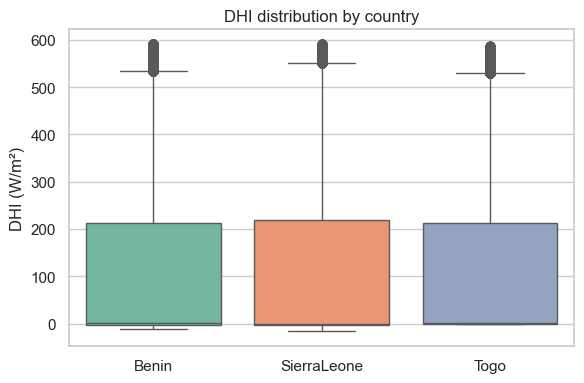

In [6]:
# Cell 4: boxplots for GHI, DNI, DHI
metrics = ['GHI', 'DNI', 'DHI']
for m in metrics:
    if m in df_all.columns and not df_all[m].dropna().empty:
        plt.figure(figsize=(6,4))
        sns.boxplot(x='country', y=m, data=df_all, palette='Set2')
        plt.title(f"{m} distribution by country")
        plt.ylabel(f"{m} (W/m²)")
        plt.xlabel('')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Metric {m} missing or empty in combined dataframe.")

### Summary Table  (mean, media, standard deviation)

In [7]:
agg_funcs = {m: ['mean','median','std'] for m in metrics}
summary = df_all.groupby('country').agg(agg_funcs)
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary = summary.reset_index()
print("### Summary table: mean / median / std for GHI, DNI, DHI")
print(summary)

### Summary table: mean / median / std for GHI, DNI, DHI
       country    GHI_mean  GHI_median     GHI_std    DNI_mean  DNI_median  \
0        Benin  236.234508         0.7  328.288787  166.896673        -0.1   
1  SierraLeone  185.000024        -0.4  279.019460  104.128943        -0.1   
2         Togo  223.859675         0.5  317.306277  147.975931         0.0   

      DNI_std    DHI_mean  DHI_median     DHI_std  
0  262.081997  111.656477         0.5  153.099749  
1  200.954182  108.104278        -0.6  153.691835  
2  247.683690  112.781249         1.5  151.571744  


### Statistical tests on GHI across countries

In [8]:
available = [name for name,d in dfs.items() if 'GHI' in d.columns and not d['GHI'].dropna().empty]
groups = [dfs[name]['GHI'].dropna() for name in available]
print("Groups included:", available)

if len(groups) >= 2:
    # Normality quick check (Shapiro for smaller samples)
    normal_flags = []
    for g in groups:
        try:
            if 3 <= len(g) <= 5000:
                _, p_sh = stats.shapiro(g.sample(min(len(g), 5000), random_state=0))
                normal_flags.append(p_sh > 0.05)
            else:
                normal_flags.append(False)
        except Exception:
            normal_flags.append(False)
    print("Approx normal by Shapiro (True = fail to reject normality):", normal_flags)

    # ANOVA
    try:
        fstat, p_anova = stats.f_oneway(*groups)
        print(f"One-way ANOVA: F={fstat:.3f}, p={p_anova:.4g}")
    except Exception as e:
        print("ANOVA failed:", e)

    # Kruskal-Wallis (non-parametric)
    try:
        hstat, p_kw = stats.kruskal(*groups)
        print(f"Kruskal-Wallis: H={hstat:.3f}, p={p_kw:.4g}")
    except Exception as e:
        print("Kruskal-Wallis failed:", e)
else:
    print("Not enough countries with GHI to compare (need at least 2).")

Groups included: ['Benin', 'SierraLeone', 'Togo']
Approx normal by Shapiro (True = fail to reject normality): [False, False, False]
One-way ANOVA: F=3833.184, p=0
Kruskal-Wallis: H=6548.534, p=0


### Ranking by mean GHI (bar chart)

C:\Users\HP\AppData\Local\Temp\ipykernel_20552\3044669514.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GHI_mean', y='country', data=rank, palette='viridis')


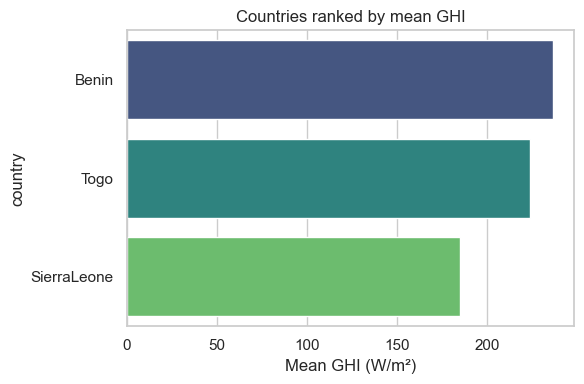

In [9]:
if 'GHI_mean' in summary.columns:
    rank = summary[['country','GHI_mean']].sort_values('GHI_mean', ascending=False)
    plt.figure(figsize=(6,4))
    sns.barplot(x='GHI_mean', y='country', data=rank, palette='viridis')
    plt.xlabel('Mean GHI (W/m²)')
    plt.title('Countries ranked by mean GHI')
    plt.tight_layout()
    plt.show()
else:
    print("GHI_mean not found in summary table; cannot plot ranking.")

### Key Observations

* **Benin** shows the highest mean GHI (236.23 W/m²) and DNI, followed by **Togo** and **Sierra Leone**; DHI values are similar across countries.
* **Benin** also has the greatest variability (std ≈ 328.29) and the widest IQR/outlier range, while medians are near zero due to nighttime values.
* **ANOVA** and **Kruskal–Wallis** tests (p ≈ 0 ≪ 0.05) confirm **significant GHI differences** among the three countries, even though normality assumptions fail.
